# Quantum Image Processing - FRQI Image Emebedding

FRQI stand for Flexible Representation of Quantum Images

This notebook is a inspired from the original Qiskit Textbook chapter 4.2.2 [[1]](https://qiskit.org/textbook/ch-applications/image-processing-frqi-neqr.html); made in order to practice/implement the techniques provided in the textbook.

[[1]](https://qiskit.org/textbook/ch-applications/image-processing-frqi-neqr.html) mentions that Quantum Image processing is an up and developing field that promises speed-up in the area of image processing. Quantum algorithms like the novel quantum image edge detection algorithm QSobel by Zhang et al. (2014) [[2]]() can extract the edge information from an FRQI quantum image of size $2^n \times 2^n$ with a computational complexity of $O(n^2)$. This complexity is lower than the classical counterpart of the algorithm, Sobel.

This notebook, like the original Qiskit Textbook chapter [[1]](https://qiskit.org/textbook/ch-applications/image-processing-frqi-neqr.html), covers methods of image encoding in the quantum computers only. This notebook can be further developed to have implementations of algorithms like QSobel.

## FRQI (Flexible Representation of Quantum Images)

FRQI image embedding method represents images according to the following equation. Here, the pixel (intensity) values are encoded in angle of rotation of the $R_y(\theta)$ gate with the help of Angle Encoding method.

In [50]:
# Imports
import math
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, ParameterVector
from qiskit.visualization import plot_histogram

# Imports for Noisy Simulation
from qiskit.providers.fake_provider import FakeQasmSimulator, FakeManila
from qiskit_aer.noise import NoiseModel

# Imports for Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

Notes:

Image size = 2x2; Feature dimen = 2 = sqrt(image_dimen)??; num_theta = 2x2 = 4

In [13]:
def pixel_position(feature_dimen, pixel_pos_binary):
    
    circ = QuantumCircuit(feature_dimen)
    
    for index, value in enumerate(pixel_pos_binary):
        if value == '1':
            circ.x(index)
                
    return circ

def color_info(feature_dimen, pixel_pos, pixel_vals):
    
    qr = QuantumRegister(feature_dimen)
    circ = QuantumCircuit(qr)
    
#     theta = ParameterVector("θ", num_theta)    # theta = intensity of color. Maybe color value = theta ?
    
    circ.cry(pixel_vals[pixel_pos], target_qubit = feature_dimen - 1, control_qubit = feature_dimen - 3)
    circ.cx(0, 1)
    circ.cry(-pixel_vals[pixel_pos], target_qubit = feature_dimen - 1, control_qubit = feature_dimen - 2)
    circ.cx(0, 1)
    circ.cry(pixel_vals[pixel_pos], target_qubit = feature_dimen - 1, control_qubit = feature_dimen - 2)

    return circ

def frqi_image_encoding(image_size, feature_dimen, pixel_vals):
    
    qr = QuantumRegister(feature_dimen + 1)
    circ = QuantumCircuit(qr)
    
    for i in range(feature_dimen):
        circ.h(i)
    
    num_theta = math.prod(image_size)
    for pixel in range(num_theta):
        pixel_pos_binary = "{0:2b}".format(pixel) # {<index of element in format>: <digits required> <binary b>}
        
        # Embedd pixel position on qubits
        circ.append(pixel_position(feature_dimen, pixel_pos_binary), [qr[i] for i in range(feature_dimen)])

        # Embedd color information on qubits
        circ.append(color_info(feature_dimen + 1, pixel, pixel_vals), [qr[i] for i in range(feature_dimen + 1)])
        
        # Remove pixel embedding
        circ.append(pixel_position(feature_dimen, pixel_pos_binary), [qr[i] for i in range(feature_dimen)])
    
    return circ

First, let us consider greyscale images. For such images, the values of pixel intensities is binary - 0 (minimum intensity) or 1 (maximum intensity), depending on if the pixels are black or white respectively.

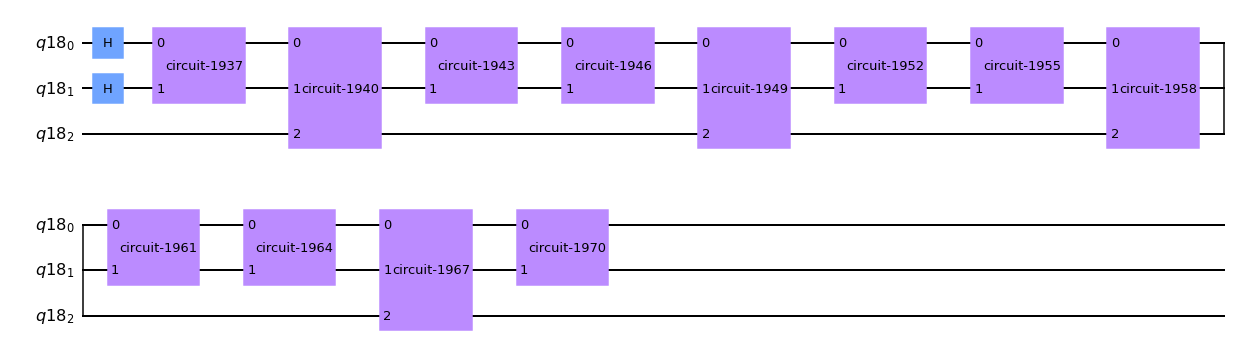

In [14]:
# Greyscale pixel intensity values
pixel_vals = [0, math.pi/2, math.pi/2, 0]
feature_dimen = 2
image_size = (2, 2)

# Calling the FRQI embedding function
circ = frqi_image_encoding(image_size, feature_dimen, pixel_vals)
circ.draw('mpl')

The next step is to measure the circuit to see that the results 

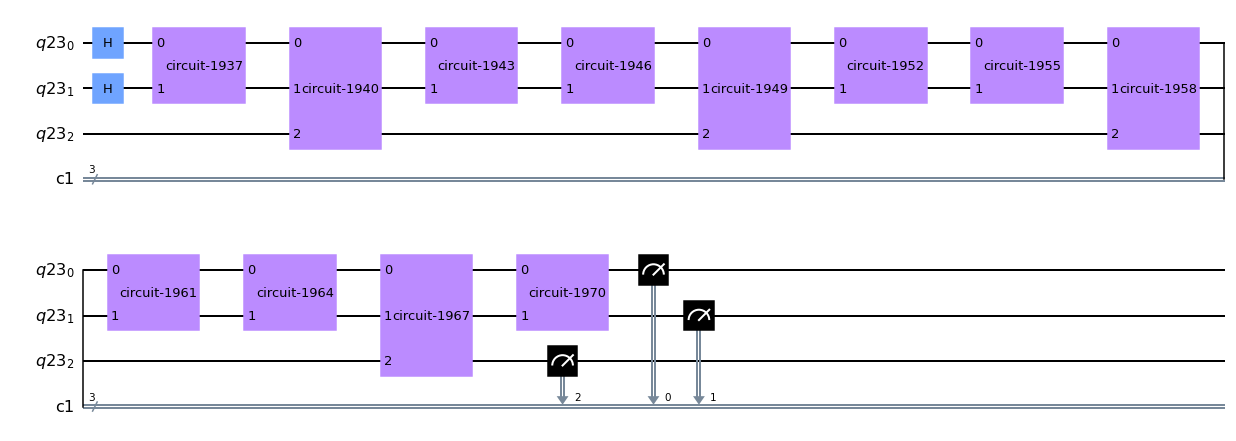

In [15]:
# Append mearuement gates to the circuit
qr = QuantumRegister(feature_dimen + 1)
cr = ClassicalRegister(feature_dimen + 1)

meas_circ = QuantumCircuit(qr, cr)
meas_circ.measure([i for i in range(feature_dimen + 1)], [i for i in range(feature_dimen + 1)])
meas_circ = meas_circ.compose(circ, range(feature_dimen + 1), front = True)
meas_circ.draw('mpl')

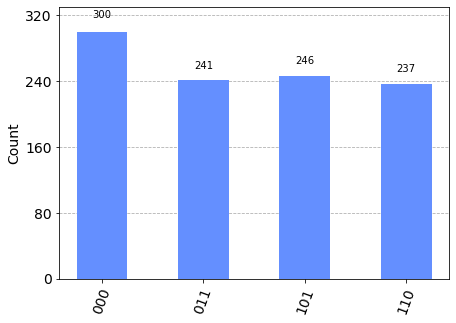

In [16]:
# Measurement
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_circ, backend = backend, shots = 1024)
results = job.result()
counts = results.get_counts()
plot_histogram(counts)

# Noisy Simulation

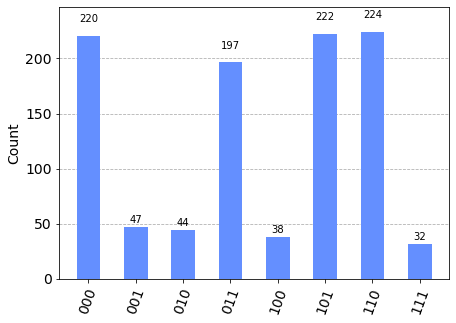

In [17]:
noisy_backend = FakeManila()

job = execute(meas_circ, backend = noisy_backend, shots = 1024)
noisy_counts = job.result().get_counts()
plot_histogram(noisy_counts)

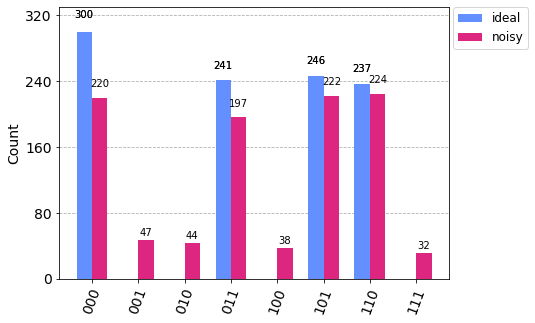

In [18]:
# Comparing ideal and noisy results

legend = ['ideal', 'noisy']
plot_histogram([counts, noisy_counts], legend = legend)

# Qiskit Runtime

In [19]:
# Get Qiskit Runtime running

service = QiskitRuntimeService()
runtime_backend = service.backends(simulator = True)[0]
options = Options(simulator = {"seed_simulator": 42}, rescilience_level = 0)

In [38]:
with Session(service = service, backend = runtime_backend):
    sampler = Sampler(options = options)
    job = sampler.run(circuits = meas_circ)
    
runtime_result = job.result()
print(runtime_result)

SamplerResult(quasi_dists=[{3: 0.25375, 5: 0.259, 0: 0.24175, 6: 0.2455}], metadata=[{'header_metadata': {}, 'shots': 4000}])


In [39]:
runtime_result.quasi_dists

# Here, [3, 5, 0, 6] are decimal form of expected/ideal binary counts.

[{3: 0.25375, 5: 0.259, 0: 0.24175, 6: 0.2455}]

In [34]:
#  Noisy Runtime results

noisy_runtime_backend = FakeManila()
noise_model = NoiseModel.from_backend(noisy_runtime_backend)

noise_options = Options(
    simulator = {
        "noise_model": noise_model,
        "seed_simulator": 42
    }, 
    rescilience_level = 0)

with Session(service = service, backend = runtime_backend):
    sampler = Sampler(options = noise_options)
    job = sampler.run(circuits = meas_circ)
    
noisy_runtime_result = job.result()
print(noisy_runtime_result)

SamplerResult(quasi_dists=[{1: 0.041, 2: 0.08875, 5: 0.18075, 6: 0.212, 4: 0.073, 7: 0.027, 0: 0.21575, 3: 0.16175}], metadata=[{'header_metadata': {}, 'shots': 4000}])


In [35]:
noisy_runtime_result.quasi_dists

[{1: 0.041,
  2: 0.08875,
  5: 0.18075,
  6: 0.212,
  4: 0.073,
  7: 0.027,
  0: 0.21575,
  3: 0.16175}]

In [75]:
# Error Mitigated Runtime results

# Changes to the options to include noise_model and error mitigation technique M3 (rescilience = 1)
em_options = Options(
    simulator = {
        "noise_model": noise_model,
        "seed_simulator": 42
    }, 
    rescilience_level = 1)

with Session(service = service, backend = runtime_backend):
    sampler = Sampler(options = em_options)
    job = sampler.run(circuits = meas_circ)
    
em_runtime_result = job.result()
print(em_runtime_result)

SamplerResult(quasi_dists=[{1: 0.041, 2: 0.08875, 5: 0.18075, 6: 0.212, 4: 0.073, 7: 0.027, 0: 0.21575, 3: 0.16175}], metadata=[{'header_metadata': {}, 'shots': 4000}])


In [76]:
em_runtime_result.quasi_dists

[{1: 0.041,
  2: 0.08875,
  5: 0.18075,
  6: 0.212,
  4: 0.073,
  7: 0.027,
  0: 0.21575,
  3: 0.16175}]

In [53]:
def process_samples(circuit, samples):
    """maps dictionary of (quasi-) probabilities to dense vector for illustration.
       (scales exponentially! don't apply to too many qubits!."""
    probs = np.zeros(2**circuit.num_qubits)
    for b, p in samples.quasi_dists[0].items():
        probs[b] = p
    return probs

def plot_probabilities(circuit, probs, label):
    """plots probability vector."""
    x = np.array(range(2**circuit.num_qubits))
    fig, ax = plt.subplots()
    ax.bar(x, probs, align='center', alpha=1, label=label)
    ax.set_title('Probabilities')
    ax.yaxis.grid(True)
    ax.xaxis.set_major_formatter(lambda x, pos: f'{int(x):0{circuit.num_qubits}b}')
    plt.xticks(x[::4], rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_cumulative_probabilities(circuit, probs_list, labels):
    """plots multiple cumulative probabilities."""
    x = np.array(range(2**circuit.num_qubits))
    fig, ax = plt.subplots()
    for i, probs in enumerate(probs_list):
        ax.plot(x, np.cumsum(probs), label=labels[i], linewidth=2)
    ax.set_title('Cumulative Probabilities')
    ax.yaxis.grid(True)
    ax.xaxis.set_major_formatter(lambda x, pos: f'{int(x):0{circuit.num_qubits}b}')
    plt.xticks(x[::4], rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

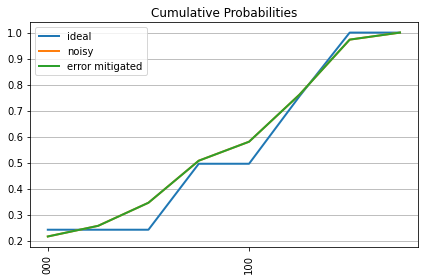

In [74]:
legend = ['ideal', 'noisy', 'error mitigated']
ideal_prob = process_samples(meas_circ, runtime_result),
noisy_prob = process_samples(meas_circ, noisy_runtime_result),
em_prob = process_samples(meas_circ, em_runtime_result)

# plot_probabilities(meas_circ, ideal_prob, label = legend)
plot_cumulative_probabilities(meas_circ, [ideal_prob, noisy_prob, em_prob], labels = legend)

# End Notes

Following are few questions that still need to be addressed.

1. Does this technique work with square images only? Try embedding rectangular images!
2. Try using qiskit runtime with it. 
3. Why do we choose the ... gradient descent algorithm?